# Shape Analysis

After finding atlas correspondence points across a shape population we can find insights into how shape informs other metrics and classes. In this example we train a Distance-Weighted Discrimination (DWD) classifier to predict whether a given mouse femur is healthy/unhealthy based on its shape features.

DWD classification is designed to work with High-Dimensional Low Sample Size (HDLSS) data where the number of features for a given sample significantly outnumbers the total number of samples in the data set. In this case we have 28 mouse femur samples, each of which is represented by approximately 4000 points in three-dimensional space. We use DWD to get a hyperplane separating the feature space for healthy and unhealthy femur classes and analyze prediction accuracy and distance to the hyperplane in order to assess performance.

This notebook assumes that a population of shapes in correspondence is available for training the DWD classifier. See the `TemplateGenerationIterative` notebook for a procedure to create a representative atlas from a shape population and the `MeshToMeshRegistration` notebook for examples of getting correspondence points on individual samples with the generated atlas.

In [ ]:
import sys
!{sys.executable} -m pip install itk dwd sklearn seaborn matplotlib pandas

In [2]:
import os
import glob

from dwd.dwd import DWD
import itk
import numpy as np
import sklearn.model_selection
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from src.hasi.hasi import classify

### Load Correspondence Meshes

In [3]:
CORRESPONDENCE_INPUT = 'Output/correspondence/'

paths = glob.glob(CORRESPONDENCE_INPUT+'*')
print(len(paths))

28


In [4]:
meshes = [itk.meshread(path, itk.F) for path in paths]

# Get femur class from filename: right femurs are healthy, left feurs are unhealthy
labels = np.array(['Healthy' if '-R' in path else 'Unhealthy' for path in paths])


print(f'{len(meshes)} shapes found')
print(f'{len(labels[labels == "Healthy"])} healthy samples, '
      f'{len(labels[labels == "Unhealthy"])} unhealthy samples')

assert(not any(mesh.GetNumberOfPoints() != meshes[0].GetNumberOfPoints()
              for mesh in meshes[1:]))
print(f'Meshes each have {meshes[0].GetNumberOfPoints()} points')

28 shapes found
14 healthy samples, 14 unhealthy samples
Meshes each have 3817 points


### Prepare Data

DWD expects input of size `n x d` where `n` = number of samples and `d` = number of features. We can generate the shape features for a given mesh by flattening the list of 3D points to one dimension, however for our given population this exceeds DWD's memory availability. For this example we use a step size of 10 to select every tenth point for inclusion in the feature array, leading to a feature length of (int(3817 / 10) * 3) ~= 1146 for each sample.

In [5]:
features = classify.make_point_features(meshes, step=10)
print(features.shape)

(28, 1146)


We use `sklearn` to split the data set into samples for training and testing.

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features,labels, train_size=0.6, random_state=73)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16, 1146)
(16,)
(12, 1146)
(12,)


### Train Classifier

Here we fit the DWD classifier to the training set and then verify with the testing set.

In [8]:
classifier = DWD(C='auto')
classifier.fit(X_train,np.squeeze(y_train))

DWD(C=9.989272474981702)

In [9]:
predict = classifier.predict(X_test)
correct = np.squeeze(predict) == y_test

print(f'{float(sum(correct) / len(correct)):0.2%} correct')
print(correct)

83.33% correct
[ True  True  True False False  True  True  True  True  True  True  True]


In [10]:
# Print distances to separating hyperplane
print(classify.get_distances(classifier, X_test))

[ 0.51246972  1.37529028 -0.88142607  1.36234602 -0.78152306 -1.09616038
 -0.1393085   0.32118888 -0.90293256 -0.69205907 -1.07170148 -0.70416412]


### Visualize Results

We can examine the fitness of the hyperplane by comparing the distance to the hyperplane for each test sample.

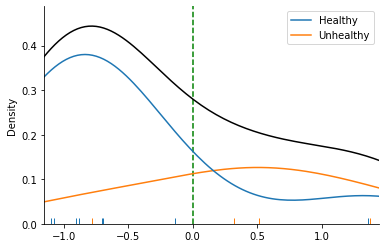

In [11]:
# Density plot
test_distances = classify.get_distances(classifier, X_test)
classify.densityplot(test_distances, np.squeeze(y_test))

In [12]:
X = pd.DataFrame(test_distances, columns=['Distance'])
y = pd.DataFrame(y_test, columns=['Label'])
X['Label'] = y

X.head()

,Distance,Label
0,0.512470,Unhealthy
1,1.375290,Unhealthy
2,-0.881426,Healthy
3,1.362346,Healthy
4,-0.781523,Unhealthy


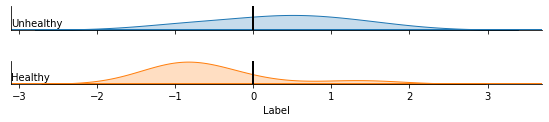

In [13]:
# Ridge plots
classify.density_by(X,'Label')